In [1]:
from tdc.multi_pred.anndata_dataset import DataLoader
from tdc.model_server.tokenizers.scgpt import scGPTTokenizer

# Load dataset (AnnData object)
adata = DataLoader("cellxgene_sample_small", "./data", dataset_names=["cellxgene_sample_small"], no_convert=True).adata
gene_ids = adata.var["feature_name"].to_numpy()

# Tokenize
tokenizer = scGPTTokenizer()
tokenized_data = tokenizer.tokenize_cell_vectors(adata.X.toarray(), gene_ids)

Downloading...
100%|██████████| 103M/103M [00:06<00:00, 16.6MiB/s] 
Loading...
loading anndata object...
loader anndata object!
Found local copy...


In [2]:
from tdc import tdc_hf_interface
scgpt = tdc_hf_interface("scGPT")
model = scgpt.load().eval().cuda()  # or .cpu() if no GPU

In [4]:
import torch

embeddings = []

with torch.no_grad():
    for token_ids, counts in tokenized_data:
        input_ids = torch.tensor(token_ids).unsqueeze(0).to(model.device)
        values = torch.tensor(counts).unsqueeze(0).to(model.device)
        attention_mask = (values != 0).bool()

        out = model(input_ids=input_ids,
                    values=values,
                    attention_mask=attention_mask)

        cell_emb = out["cell_emb"]  # shape: (1, hidden_dim)
        embeddings.append(cell_emb.squeeze().cpu().numpy())

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

X = np.stack(embeddings)
y = adata.obs["cell_type"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

clf = LogisticRegression(max_iter=1000).fit(X, y_encoded)
y_pred = clf.predict(X)
print(classification_report(y_encoded, y_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

    Schwann cell       0.00      0.00      0.00         3
          T cell       0.00      0.00      0.00       881
endothelial cell       0.00      0.00      0.00         1
 epithelial cell       0.00      0.00      0.00       232
      fibroblast       0.00      0.00      0.00        43
        pericyte       0.00      0.00      0.00         2
         unknown       0.77      1.00      0.87      3830

        accuracy                           0.77      4992
       macro avg       0.11      0.14      0.12      4992
    weighted avg       0.59      0.77      0.67      4992



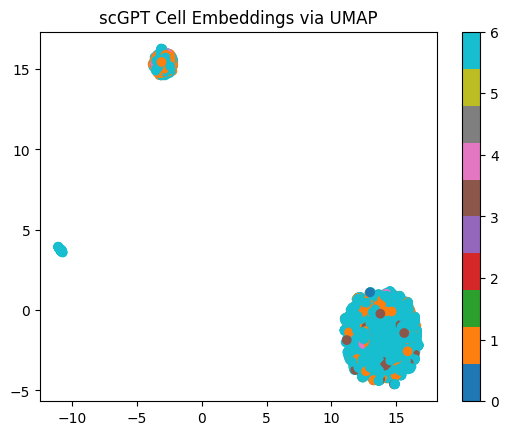

In [8]:
import umap
import matplotlib.pyplot as plt

X_umap = umap.UMAP().fit_transform(X)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_encoded, cmap="tab10")
plt.colorbar()
plt.title("scGPT Cell Embeddings via UMAP")
plt.show()